In [25]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [26]:
batch_size = 128 # batch size
n_epochs = 10 # number of epochs
lr = 0.01 # learning rate
n_hid = 100 # number of neurons in the hidden layer
n_vis = 28*28 # input size
k = 3 # The number of Gibbs sampling

In [27]:
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k=1, *args, **kwargs):
        super(RBM, self).__init__(*args, **kwargs)
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def visible_to_hidden(self, v):
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v):
        v_term = torch.matmul(v, self.v.t())
        w_x_h = F.linear(v, self.W, self.h)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, v):
        h = self.visible_to_hidden(v)
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)
        return v_gibb


In [28]:
class Encoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.fc1 = nn.Linear(n_vis, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
    
    def forward(self, v):
        v = torch.relu(self.fc1(v))
        v = self.fc2(v)
        return v

class Decoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.fc1 = nn.Linear(n_hid, n_vis)
        self.fc2 = nn.Linear(n_vis, n_vis)
    
    def forward(self, h):
        h = torch.relu(self.fc1(h))
        h = self.fc2(h)
        return h

class AutoEncoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.enc = Encoder(n_vis, n_hid)
        self.dec = Decoder(n_vis, n_hid)

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

    def visible_to_hidden(self, v):
        return self.enc(v)
    
    def hidden_to_visible(self, h):
        return self.dec(h)


In [29]:
# model = RBM(n_vis=n_vis, n_hid=n_hid, k=k)
model = AutoEncoder(n_vis=n_vis, n_hid=n_hid)

In [30]:
train_datasets = datasets.MNIST(
    root='./output',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
    )
train_loader = torch.utils.data.DataLoader(
    dataset=train_datasets,
    batch_size=batch_size,
    shuffle=True,
)

In [31]:
def neuron_fireing_vis():
    vv1 = np.zeros((len(train_datasets), n_hid))

    for idx, (x, y) in enumerate(train_loader):
        x = x.view(-1, n_vis)
        vv1[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(x).detach().numpy() # [batch_size, n_hid]
    return vv1

In [32]:
from tqdm import tqdm

loss_ = []
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model.train()

loss_func = F.mse_loss

neuron_fireings = []
neuron_fireings.append(neuron_fireing_vis())
with tqdm(range(n_epochs)) as t:
    for epoch in t:
        for (data, target) in train_loader:
            v = data.view(-1, n_vis)
            out = model(v)
            loss = loss_func(v, out)
            loss_.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss={loss.item():.2}")
        neuron_fireings.append(neuron_fireing_vis())


loss=0.064: 100%|██████████| 10/10 [03:28<00:00, 20.83s/it]


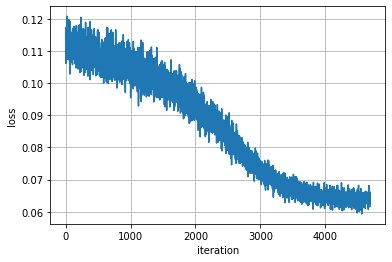

In [33]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.xlabel('iteration')
plt.ylabel('loss')
# plt.ylim(0, 300)
plt.grid()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


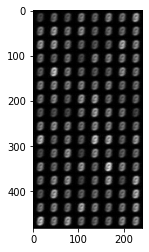

In [34]:
from torchvision.utils import make_grid

images = next(iter(train_loader))[0]
v = images.view(-1, 784)
output = model(v)
npimg = np.transpose(make_grid(output.view(batch_size, 1, 28, 28).data).numpy(), (1, 2, 0))
plt.imshow(npimg, cmap="gray")

In [35]:
vv1 = np.zeros((len(train_datasets), n_hid))

for idx, (x, y) in enumerate(train_loader):
    x = x.view(-1, n_vis)
    vv1[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(x).detach().numpy() # [batch_size, n_hid]

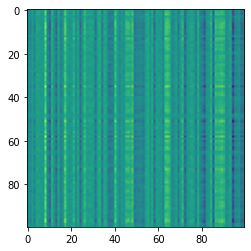

In [36]:
plt.imshow(vv1[:100, :])


In [37]:
import sklearn
from sklearn.decomposition import PCA

vv1 = sklearn.preprocessing.scale(vv1)

In [38]:
pca = PCA()
pca.fit(vv1)
print(pca.explained_variance_)

[5.24485915e+01 6.19247128e+00 4.57513802e+00 3.90873604e+00
 3.33053204e+00 2.63588389e+00 2.52598383e+00 2.01830790e+00
 1.96508459e+00 1.66109678e+00 1.49757648e+00 1.39405332e+00
 1.29060229e+00 1.27234497e+00 1.11939506e+00 1.02654669e+00
 8.67064114e-01 8.13057974e-01 7.40790588e-01 6.79781778e-01
 6.17431817e-01 5.46627281e-01 5.03526220e-01 4.87556312e-01
 4.58208087e-01 4.25538689e-01 3.87497603e-01 3.45511485e-01
 3.09422746e-01 2.94869457e-01 2.77631019e-01 2.44855572e-01
 2.35275866e-01 2.02723340e-01 1.89001286e-01 1.86080065e-01
 1.70174888e-01 1.57218422e-01 1.44949560e-01 1.34013195e-01
 1.32539756e-01 1.15558788e-01 1.11221679e-01 1.01564870e-01
 1.00377473e-01 9.01197666e-02 8.06732009e-02 7.64294954e-02
 7.09732117e-02 6.77589283e-02 6.37259970e-02 5.83272796e-02
 5.61237292e-02 5.22043837e-02 4.92959334e-02 4.33295382e-02
 4.16386213e-02 3.75294565e-02 3.54170240e-02 3.23640681e-02
 2.97006999e-02 2.78235623e-02 2.41263405e-02 2.26592770e-02
 2.17806938e-02 1.883721

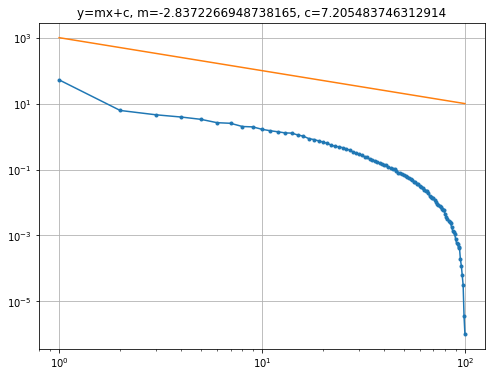

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')
ax.plot(xx, 1000 * xx ** (-1.0))

ax.set_xscale('log')
ax.set_yscale('log')
xx = np.log(xx)
yy = np.log(pca.explained_variance_)
m, c = np.linalg.lstsq(np.vstack([xx, np.ones(len(xx))]).T, yy, rcond=None)[0]
ax.set_title(f'y=mx+c, m={m}, c={c}')
ax.grid()

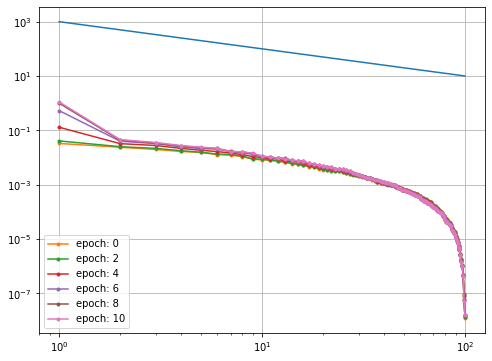

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
for i, vv in enumerate(neuron_fireings):
    if i % 2 == 1:
        continue
    pca = PCA()
    pca.fit(vv)
    ax.plot(xx, pca.explained_variance_, '.-', label=f"epoch: {i}")
plt.legend()
ax.grid()